# Autopi video processing

This file is processing the arena_top.avi file generated during the autopi task. 

Most of the code was written for the CA1-autopi manuscript in a notebook called `autopi_analysis/ca1_2021/position_tracking`.

Steps with the `arena_top.avi` file

* Detect the bridge and arena in arena_top.avi
* Crop the arena_top.avi to 480x480

Steps with the cropped video

* Detect arena in cropped video
* Detect bridge in cropped video
* Detect the mouse and lever in cropped video (mouse detection is not very good because the mouse has a cable and LEDs and the model was not trained with this, we use a different model later on)

There is a jupyter notebook in `autopi_analysis/kevin/autopipy_dev_notebooks` in which all the steps for a single session are performed separately. This is a good place to go if you have problems running the analysis on one session.

All the processing steps are now packaged in `autopipy.video_utilities.positionTrackingFromArenaTopVideo()`. You only have to run this function to get the work done.

Below is the code to run the analysis on several sessions. 

It takes approximately **30 minutes per session** with a decent GPU. You can of course run different sessions on different GPU to speed up the process.

You will need to run this code from a DLC-GPU virtual environment.


**These steps were performed by TYY. I just double-checked that it worked correctly.**

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["DLClight"]="True" # if you don't need dlb gui
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os.path
import autopipy
import importlib
from autopipy.project import Project

%matplotlib inline

In [2]:
projectName="autopi_mec"
dataPath="/adata/projects/autopi_mec"
dlcModelPath="/adata/models"
bridgeModel1 ="bridgeDetection_640_480-Allen-2021-02-10"
mouseLeverModel ="arena_top-Allen-2019-10-30"
bridgeModel2 = "bridgeDetection_480_480-Allen-2021-01-23"
arenaMinRadius= 190
arenaMaxRadius= 260


myProject = Project(name=projectName,dataPath=dataPath,dlcModelPath=dlcModelPath)
fn=myProject.dataPath+"/sessionList_invalid"
print("Reading " + fn)
sessionNames = pd.read_csv(fn) # this will be a pandas dataframe
print("We have {} testing sessions in the list".format(len(sessionNames)))
myProject.createSessionList(sessionNameList=sessionNames.sessionName.to_list()) 

Project name: autopi_mec
dataPath: /adata/projects/autopi_mec
dlcModelPath: /adata/models
Reading /adata/projects/autopi_mec/sessionList_invalid
We have 1 testing sessions in the list


In [3]:
for i,ses in enumerate(myProject.sessionList):
    print(ses.name)

mn8578-30112021-0107


## Arena detection

TYY had done the arena detection. The code is in `autopi_analysis/kevin/autopipy_dev_notebooks` if needed.

I just double-checked that it had worked.

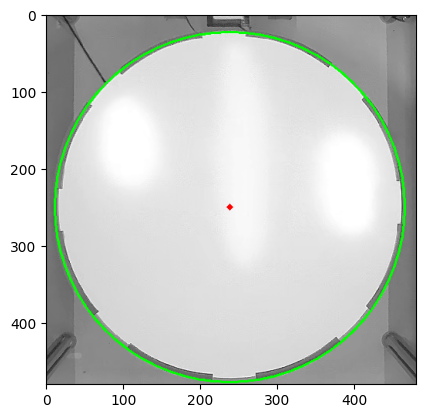

In [4]:
from autopipy.cvObjectDetectors import ArenaDetector

for i,ses in enumerate(myProject.sessionList):
    videoFile = ses.fileNames["arena_top.avi"] #Nice trick to get file names using a dict
    arenaImageFile=ses.path+"/arenaDetection.png"

    if not os.path.exists(videoFile):
        print(ses.name, videoFile, "missing")
    
    if not os.path.exists(arenaImageFile):
        print(ses.name, arenaImageFile, "missing")
    
    im = Image.open(arenaImageFile)
    plt.imshow(im)
    plt.show()

In [5]:
from autopipy.cvObjectDetectors import ArenaDetector

for i,ses in enumerate(myProject.sessionList[43:]):
    videoFile = ses.fileNames["arena_top.cropped.avi"] #Nice trick to get file names using a dict
    arenaImageFile=ses.path+"/arenaDetectionCropped.png"
    if not os.path.exists(videoFile):
        print(ses.name, videoFile, "missing")
    
    if not os.path.exists(arenaImageFile):
        print(ses.name, arenaImageFile, "missing")

    im = Image.open(arenaImageFile)
    plt.imshow(im)
    plt.show()


## Bridge detection



2024-02-13 10:08:24.372983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 10:08:25.070577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading DLC 2.2.3...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


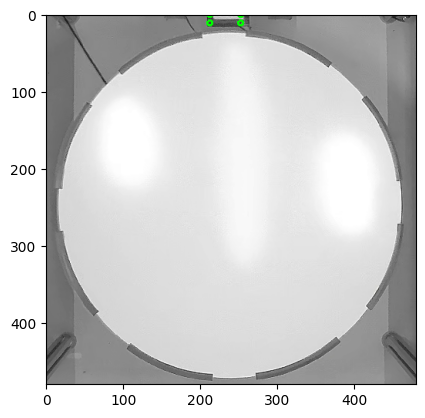

In [6]:
from autopipy.dlcObjectDetectors import BridgeDetector

for i,ses in enumerate(myProject.sessionList):
    videoFile = ses.fileNames["arena_top.avi"] #Nice trick to get file names using a dict
    bridgeImageFile = ses.path+"/bridgeDetection.png"
    
    if not os.path.exists(bridgeImageFile):
        print(ses.name, bridgeImageFile, "missing")
    
    
    im = Image.open(bridgeImageFile)
    plt.imshow(im)
    plt.show()

# Tracking of the mouse and lever

This was done by TYY before leaving.

The positionTrackingFromArenaTopVideo takes care of all the processing steps of the `arena_top.avi`. 

In [7]:
from autopipy.video_utilities import positionTrackingFromArenaTopVideo
for i, ses in enumerate(myProject.sessionList):
    fn = ses.fileNames["mouseLeverPosition.csv"]
    if not os.path.exists(fn):
        print(i, ses.name, fn, "is missing")

All the files were there. I re-ran on a few sessions and generated a label video to ensure that the tracking is good.

It takes 1 hour per session with a old NVIDIA GeForce GTX 1080.

In [8]:
ses.fileNames
positionTrackingFromArenaTopVideo(ses,modelDir=dlcModelPath,
                                  arenaMinRadius=140,arenaMaxRadius=230, 
                                  arenaCircleMethod="median",labelDlcMouseLeverVideo=True)

Startint at 10:08:34
labelImage: /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/arenaDetection.png
/tmp/tmpVid.avi created for bridge detection
Start date and time = 13/02/2024 10:10:03
Running dlc.analyze_video on /tmp/tmpVid.avi
Using snapshot-460000 for model /adata/models/bridgeDetection_640_480-Allen-2021-02-10/dlc-models/iteration-0/bridgeDetection_640_480Feb10-trainset95shuffle1


/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2024-02-13 10:10:05.065772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 10:10:05.080858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 10:10:05.081031

Starting to analyze %  /tmp/tmpVid.avi
Loading  /tmp/tmpVid.avi
Duration of video [s]:  33.33 , recorded with  30.0 fps!
Overall # of frames:  1000  found with (before cropping) frame dimensions:  480 480
Starting to extract posture


  0%|          | 0/1000 [00:00<?, ?it/s]2024-02-13 10:10:09.079945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-02-13 10:10:10.079945: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-13 10:10:10.080972: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-02-13 10:10:10.080981: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-02-13 10:10:10.081020: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This messa

Saving results in /tmp...
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5
Saving position data to /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.csv
End date and time = 13/02/2024 10:10:21
dlc.loadPositionData() read data from /tmp/tmpVidDLC_resnet50_bridgeDetection_640_480Feb10shuffle1_460000.h5


IndexError: invalid index to scalar variable.